In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TrialSolution import TrialSolution

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [2]:
X_train = np.arange(0, 2., 0.2) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 2., 0.01) + 1e-8
X_test = X_test.reshape(-1,1) 

In [3]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=X.shape)}]

The trial solution for this case is $\Psi(x)=x N(x)$.
The first function below is the function $A(x)=0$
and the second function is the function $B(x)=x$.
Though, in our case, the trial solution is generated automatically from the initial conditions.

In [4]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1, equation_type='ODE')

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [5]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(inputs)
    tape.watch(inputs)
    response = network(inputs)
  grads = tape.gradient(response, inputs)
  loss = tf.square(grads + tf.multiply(tf.constant(0.2, dtype='float64'), response)
          - tf.multiply(tf.exp( tf.multiply(tf.constant(-0.2, dtype='float64'), inputs)), tf.cos(inputs)))
  return loss

### Training

In [6]:
ts.train(X=X_train, diff_loss=diff_loss, epochs=100000, message_frequency=1000, optimizer_name='SGD', learning_rate=0.01)


Epoch: 1000 Loss: 0.006759554147720337
Epoch: 2000 Loss: 0.0038371470291167498
Epoch: 3000 Loss: 0.002803412964567542
Epoch: 4000 Loss: 0.0022645338904112577
Epoch: 5000 Loss: 0.0019297762773931026
Epoch: 6000 Loss: 0.0016994832549244165
Epoch: 7000 Loss: 0.0015300221275538206
Epoch: 8000 Loss: 0.001399194705300033
Epoch: 9000 Loss: 0.0012944851769134402
Epoch: 10000 Loss: 0.0012082895264029503
Epoch: 11000 Loss: 0.0011357155162841082
Epoch: 12000 Loss: 0.0010734682437032461
Epoch: 13000 Loss: 0.0010192476911470294
Epoch: 14000 Loss: 0.0009713944746181369
Epoch: 15000 Loss: 0.000928681343793869
Epoch: 16000 Loss: 0.0008901768014766276
Epoch: 17000 Loss: 0.0008551605860702693
Epoch: 18000 Loss: 0.0008230593521147966
Epoch: 19000 Loss: 0.0007934183231554925
Epoch: 20000 Loss: 0.0007658619433641434
Epoch: 21000 Loss: 0.0007400873582810163
Epoch: 22000 Loss: 0.0007158427615649998
Epoch: 23000 Loss: 0.0006929232622496784
Epoch: 24000 Loss: 0.0006711635505780578
Epoch: 25000 Loss: 0.00065043

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

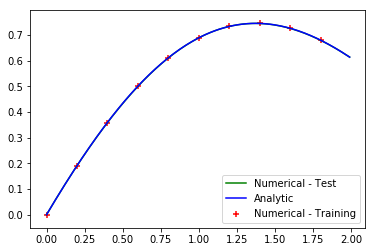

In [7]:
pred_train = ts.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test = ts(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
plt.plot(X_test,  np.exp(-0.2*X_test)*np.sin(X_test), c='b', label='Analytic')
plt.legend()
plt.show()

Let's check the errors on the training set.

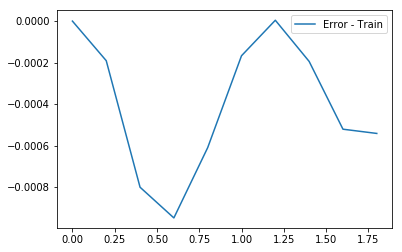

In [8]:
plt.plot(X_train, pred_train - np.exp(-0.2*X_train)*np.sin(X_train), label='Error - Train')
plt.legend()
plt.show()

Let's check the errors on the test set.

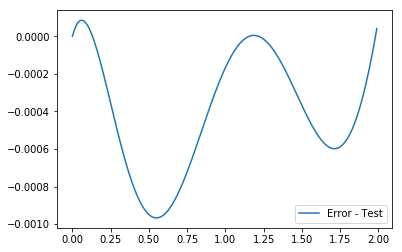

In [9]:
plt.plot(X_test, pred_test - np.exp(-0.2*X_test)*np.sin(X_test), label='Error - Test')
plt.legend()
plt.show()

The mean loss calculated on the test set.

In [10]:
diff_loss(ts, X_test).numpy().mean()

3.919702717075099e-06

Mean absolute error on the train set.

In [11]:
np.abs(pred_train - np.exp(-0.2*X_train)*np.sin(X_train)).mean()

0.00039790006968568384

Mean absolute error on the test set - interpolation error.

In [12]:
np.abs(pred_test - np.exp(-0.2*X_test)*np.sin(X_test)).mean()

0.00040447899961870476

In [13]:
np.abs(pred_test - np.exp(-0.2*X_test)*np.sin(X_test)).max()

0.0009670263823911007